# Webcrawler for TomTom traffic congestion
Source: https://www.tomtom.com/en_gb/traffic-index/ranking/
Data of 25 cities in Germany is available

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import json
import requests
import datetime as dt

## Download data and process to monthly means

In [7]:
cities_germany = ["hamburg", "berlin", "wiesbaden", "munich", "nuremberg", "stuttgart", "bonn", "kassel", "bremen", "cologne", "kiel", "dresden", "dusseldorf", "leipzig", "freiburg", "karlsruhe", "augsburg", "monchengladbach", "mannheim", "munster", "hannover", "bielefeld", "wuppertal", "ruhr-region-west", "ruhr-region-east"]
#"frankfurt-am-main" has no data for ratio to 2019

url_corona = "https://api.midway.tomtom.com/ranking/dailyStats/DEU_"

#build common dataframe
date = []
weekday = []
week = []
url_corona_munich = "https://api.midway.tomtom.com/ranking/dailyStats/DEU_munich"
req = requests.get(url_corona_munich)
json = req.json()
count = len(json)-1

# append each item in the json file to the empty lists
i=0
while i<=count:
    #for corona data
    date.append(json[i]["date"])
    weekday.append(json[i]["weekday"])
    week.append(json[i]["week"])
    i+=1
df_daily = pd.DataFrame({"date":date, "weekday": weekday, "week": week}, index=date)
df_daily.index.name = "Date"

    
for city in cities_germany:
    url_corona_city = url_corona + city
    req = requests.get(url_corona_city)
    json = req.json()

    pd.set_option("display.max_rows", False)
    # create empty lists of append data
    traffic_congestion = []
    date = []
    traffic_diffRatio_to2019 = []
    weekday = []
    week = []

    count = len(json)-1

    # append each item in the json file to the empty lists
    i=0
    while i<=count:
        #for corona data
        traffic_congestion.append(json[i]["congestion"])
        date.append(json[i]["date"])
        traffic_diffRatio_to2019.append(json[i]["diffRatio"])
        weekday.append(json[i]["weekday"])
        week.append(json[i]["week"])
        i+=1

    # create dataframe with the traffic data 
    df = pd.DataFrame({"M_TT_TrafficCongestion_" + city:traffic_congestion, "M_TT_TrafficDiffRatio20_19_" + city:traffic_diffRatio_to2019}, index=date)
    df.index.name = "Date"

    df_daily = pd.merge(df_daily, df, left_index=True, right_index=True, how='inner')
  
#convert to monthly mean
df_monthly = df_daily
df_monthly.date = pd.to_datetime(df_monthly.date).dt.to_period('m')
df_monthly = df_monthly.groupby('date').mean()


### Save dataframes as csv

In [8]:
#save daily dataframe
df_daily.to_csv('../data/mobility/raw_data/MobilityTrends/TomTom/SingleCitiesGermanyTomTom_daily2020.csv')
#save monthly dataframe
df_monthly.to_csv('../data/mobility/raw_data/MobilityTrends/TomTom/SingleCitiesGermanyTomTom_monthly2020.csv')


### Calculate a new feature by taking the mean of all cities. This feauture should represent the average city traffic congestion in Germany

In [9]:
#dataframe to take the mean of the traffic congestion
df_featureCongestion = df_monthly
#drop all ratio columns
for column in df_featureCongestion:
    if 'TrafficCongestion' not in column:
        df_featureCongestion = df_featureCongestion.drop(column, axis=1)

#mean cities and reduce dataframe to this one column that represents the average city congestion in Germany
df_featureCongestion['M_TomTomAverageCityCongestion'] = df_featureCongestion.mean(axis=1)
df_featureCongestion = df_featureCongestion[['M_TomTomAverageCityCongestion']]



#dataframe to take the mean of the difference from 2020 to 2019
df_featureRatio = df_monthly
#drop all congestion columns
for column in df_featureRatio:
    if 'TrafficDiffRatio20_19' not in column:
        df_featureRatio = df_featureRatio.drop(column, axis=1)

#mean cities and reduce dataframe to this one column that represents the average city congestion difference from 2020 to 2019 in Germany
df_featureRatio['M_TomTomAverageDiffRatio_20_To_29'] = df_featureRatio.mean(axis=1)
df_featureRatio = df_featureRatio[['M_TomTomAverageDiffRatio_20_To_29']]


#generate one dataframe with both: traffic congestion and difference from 2020 to 2019
df_feature = df_featureCongestion
df_feature['M_TomTomAverageDiffRatio_20_To_29'] = df_featureRatio['M_TomTomAverageDiffRatio_20_To_29'].values

### Save feature dataframe

In [10]:
df_feature.to_csv('../data/mobility/AverageOfCitiesGermanyTomTom_monthly.csv')

## Some plots

### Average city congestion Germany

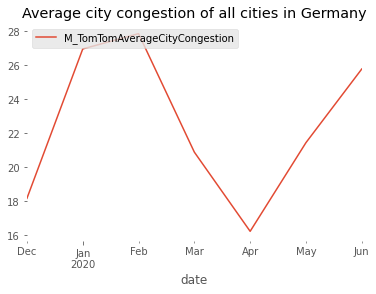

In [13]:
plt.style.use("ggplot")
df_feature.M_TomTomAverageCityCongestion.plot()
plt.title("Average city congestion of all cities in Germany")
plt.legend(loc=2)
plt.box(False)

### All cities

In [ ]:
#monthly plot
plt.style.use("ggplot")
for column in df_monthly:
    if "M_TT_TrafficDiffRatio20_19_" in column:
        ax = df_monthly[column].plot()
#ax = df_monthly["traffic_diffRatio_to2019_munich"].plot(color="Green")
plt.title("traffic_diffRatio_to2019")
#plt.legend(loc=2)
plt.box(False)
